In [42]:
import sys
import os
"""Import the basics; numpy, pandas, matplotlib et al."""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

We first implement the Mass-Metallicity relation using Eq. (5) from Zahid et al. (2014)

![image](mz_relation.png 'MZ Relation')

In [43]:
def zahid_mz_relation(mass_arr, Z0, M0, gamma):
    
    """
    :param Z0: The saturation metallicity.
    :param M0: The characteristic turnover mass above which the metallicity asymptotically
               approaches the upper metallicity limit, Z0.
    :param gamma: At stellar masses < M0, the MZ relation reduces to a power law with an index gamma
    """
    
    Z = Z0 + np.log10(1.0 - np.exp(-1*(mass_arr / M0)**gamma))
    
    return Z

In [44]:
"""Test for a linear uniform stellar mass range"""

mstar_arr = np.arange(start=10**9, stop=10**11, step=10**8)

"""Define a dictionary hosting the values for the constants from the paper"""

constants_ = {'Z0': [9.102, 9.102, 9.10, 9.08], 'M0': [10**9.219, 10**9.52, 10**9.80, 10**10.06],
              'gamma': [0.513, 0.52, 0.52, 0.61], 'survey_list':['SDSS', 'SHELS', 'DEEP2', 'COSMOS'],
              'redshift': [0.08, 0.29, 0.78, 1.55]}
# Z_ = zahid_mz_relation(m_star_arr, Z0_, M0_, gamma_)

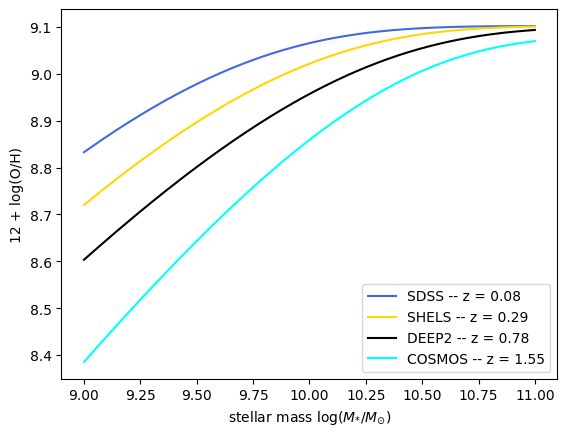

In [45]:
color_list_ = ['royalblue', 'gold', 'black', 'cyan']

for iter_ in range(len(constants_['Z0'])):
    
    Z_ = zahid_mz_relation(mstar_arr, constants_['Z0'][iter_], constants_['M0'][iter_], constants_['gamma'][iter_])

    plt.plot(np.log10(mstar_arr), Z_, color=color_list_[iter_],
             label=constants_['survey_list'][iter_]+' -- z = '+str(constants_['redshift'][iter_]))
    
plt.ylabel('12 + log(O/H)')
plt.xlabel('stellar mass log($M_{*} / M_{\odot}$)')
plt.legend(loc='best')
plt.show()

Next, we plot the star formation main sequence relation from Whitekar et al. (2014)

![image](w14_sfr_mstar.png 'SFR-Mstar Relation')

In [46]:
def whitaker14_sfr_mstar_relation(mstar_arr, a, b, char_mstar):

    """
    The SFR-Mstar relation.
    Adapted from Whitaker et al. (2014) (https://doi.org/10.1088/0004-637X/795/2/104).
    Returns the SFR in units of solar masses per year.

    Valid up to z =~ 2.5.

    :type mstar: float, in solar masses
    """

    log_SFR = np.asarray(a) * [np.log10(mstar_arr) - char_mstar] + b
    
    return log_SFR
    

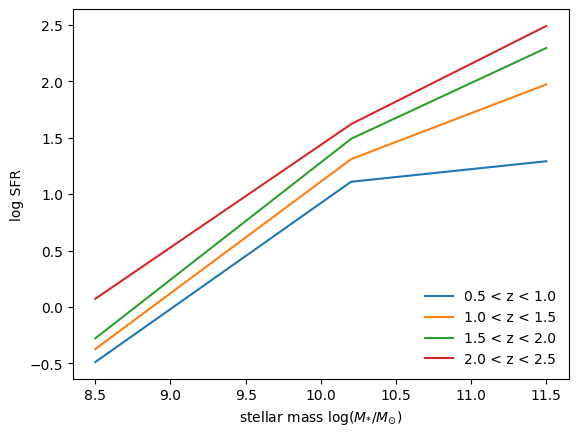

In [47]:
power_law_dict_ = {'redshift_label': ['0.5 < z < 1.0', '1.0 < z < 1.5', '1.5 < z < 2.0', '2.0 < z < 2.5'],
                   'a_low': [0.94, 0.99, 1.04, 0.91], 'a_high': [0.14, 0.51, 0.62, 0.67],
                   'b': [1.11, 1.31, 1.49, 1.62]}

w14_characteristic_mstar = 10.2
mstar_low = np.arange(start=10**8.5, stop=10**w14_characteristic_mstar, step=10**7)
mstar_high = np.arange(start=10**w14_characteristic_mstar, stop=10**11.5, step=10**7)

for sfr_iter_ in range(len(power_law_dict_['b'])):
    
    log_sfr_low_mstar = whitaker14_sfr_mstar_relation(mstar_low, power_law_dict_['a_low'][sfr_iter_],
                                               power_law_dict_['b'][sfr_iter_],
                                               w14_characteristic_mstar)
    
    log_sfr_high_mstar = whitaker14_sfr_mstar_relation(mstar_high, power_law_dict_['a_high'][sfr_iter_],
                                                power_law_dict_['b'][sfr_iter_],
                                                w14_characteristic_mstar)
    
    plt.plot(np.log10(np.append(mstar_low, mstar_high)), np.append(log_sfr_low_mstar, log_sfr_high_mstar),
             label=power_law_dict_['redshift_label'][sfr_iter_])

plt.ylabel('log SFR')
plt.xlabel('stellar mass log($M_{*} / M_{\odot}$)')
plt.legend(loc='lower right', frameon=False)
plt.show()

In [70]:
def leja22_sfr_mstar_relation(mstar_arr, redshift, coeff_dict):

    """
    The SFR-Mstar relation.
    Adapted from Leja et al. (2022) (https://iopscience.iop.org/article/10.3847/1538-4357/ac887d).
    Returns the SFR in units of solar masses per year.

    Valid up to z =~ 2.5.

    :type mstar: float, in solar masses
    """
    
    log_sfr_arr = np.zeros(len(mstar_arr))
                              
    def coeff_z_evol(z, coeff_list):
        return coeff_list[0] + coeff_list[1]*z + coeff_list[2]*np.power(z, 2)
    
    for mstar_ind, mstar in enumerate(mstar_arr.tolist()):
        
        char_mstar = coeff_z_evol(redshift, coeff_dict['char_mstar'])
        a = coeff_z_evol(redshift, coeff_dict['a'])
        b = coeff_z_evol(redshift, coeff_dict['b'])
        c = coeff_z_evol(redshift, coeff_dict['c'])
        
        if np.log10(mstar) <= char_mstar:
            log_SFR = b * (np.log10(mstar) - char_mstar) + c
        else:
            log_SFR = a * (np.log10(mstar) - char_mstar) + c
            
        log_sfr_arr[mstar_ind] = log_SFR
            
    return log_sfr_arr

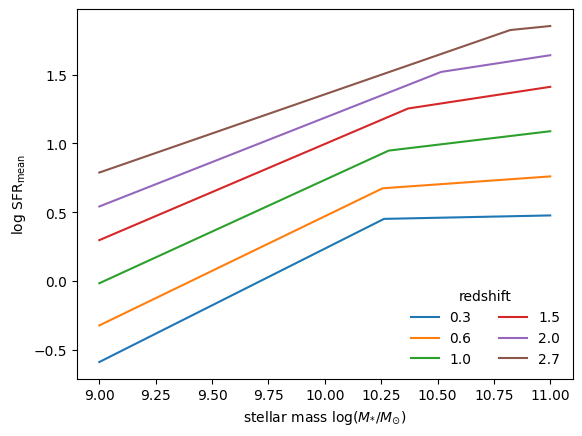

In [72]:
coefficient_dict = {'a': [-0.06707, 0.3684, -0.1047], 'b': [0.8552, -0.1010, -0.001816],
                    'c': [0.2148, 0.8137, -0.08052], 'char_mstar': [10.29, -0.1284, 0.1203]}

for redshift_ in [0.3, 0.6, 1.0, 1.5, 2.0, 2.7]:
    for leja_sfr_ in range(len(mstar_arr)):
        
        log_sfr_ = leja22_sfr_mstar_relation(mstar_arr, redshift_, coefficient_dict)

    plt.plot(np.log10(mstar_arr), log_sfr_, label=str(redshift_))

plt.ylabel('log $\mathrm{SFR_{mean}}$')
plt.xlabel('stellar mass log($M_{*} / M_{\odot}$)')
plt.legend(loc='lower right', frameon=False, title="redshift", ncol=2)
plt.show()